In [1]:
import os
import json
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import utils

In [2]:
DATA_URL = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json'

In [3]:
VOCAB_SIZE = 1000
OOV_TOKEN = '<OOV>'
MAX_LENGTH = 120
TRUNCATING = 'post'
PADDING = 'post'
TRAINING_SIZE = 20000
EMBEDDING_DIM = 16
NUM_EPOCHS = 50

In [4]:
data_dir = keras.utils.get_file(
    os.path.basename(DATA_URL),
    DATA_URL,
    cache_dir='./',
    cache_subdir=''
)

In [5]:
with open(data_dir, 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [6]:
train_sentences = sentences[0:TRAINING_SIZE]
train_labels = labels[0:TRAINING_SIZE]
val_sentences = sentences[TRAINING_SIZE:]
val_labels = labels[TRAINING_SIZE:]

In [7]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [8]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding=PADDING, truncating=TRUNCATING)
val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, maxlen=MAX_LENGTH, padding=PADDING, truncating=TRUNCATING)

train_padded = np.array(train_padded)
train_labels = np.array(train_labels)
val_sentences = np.array(val_sentences)
val_labels = np.array(val_labels)

In [9]:
def build_model_lstm():
    model = keras.Sequential([
        keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
        keras.layers.Bidirectional(keras.layers.LSTM(32)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_model_conv1d():
    model = keras.Sequential([
        keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
        keras.layers.Conv1D(128, 5, activation='relu'),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
model_lstm = build_model_lstm()
model_lstm.summary()
history_lstm = model_lstm.fit(
    train_padded, 
    train_labels, 
    epochs=NUM_EPOCHS,
    validation_data=(val_padded, val_labels), 
    verbose=1
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 32,769
Trainable params: 32,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 9s 14ms/step - loss: 0.4425 - accuracy: 0.7776 - val_loss: 0.3807 - val_accuracy: 0.8304
Epoch 2/50
625/625 [==============================] - 8s 13ms/step - loss: 0.3454 - accuracy: 0.8422 - val_

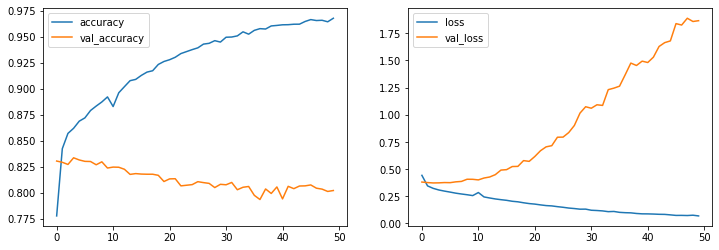

In [11]:
utils.plot_history(history_lstm)

In [12]:
model_conv1d = build_model_conv1d()
model_conv1d.summary()
history_conv1d = model_conv1d.fit(
    train_padded, 
    train_labels, 
    epochs=NUM_EPOCHS,
    validation_data=(val_padded, val_labels), 
    verbose=1
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 34,689
Trainable params: 34,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 3s 4ms/step - loss: 0.5162 - accuracy: 0.7291 - val_loss: 0.42

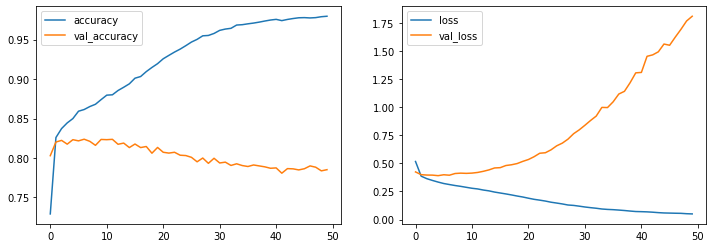

In [13]:
utils.plot_history(history_conv1d)